# NLP & Machine Learning
## <font color='#1f77b4'>Problem: Predict the year an article was published based on the content of the article.</font>

Given a set of articles, create a model that can use the content of the article to predict the year the article was published. 

# Packages

In [494]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import numpy as np
import pandas as pd
import random
import re 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import string

# Data Prep

In [495]:
#read in data
df = pd.read_csv("nyc-city-hall-catalog.csv")

In [497]:
#columns available
df.columns.values

array(['Unnamed: 0', 'Corporate Name', 'Subordinate Unit', 'Title',
       'Remainder Of Title', 'Remainder OF Title Page',
       'Date Of Publication', 'Geographic Name', 'General Subdivision'],
      dtype=object)

In [498]:
#drop the old index
df.drop('Unnamed: 0',axis=1,inplace=True)

In [499]:
df.head()

,Corporate Name,Subordinate Unit,Title,Remainder Of Title,Remainder OF Title Page,Date Of Publication,Geographic Name,General Subdivision
0,New York City.,"Laws, etc.",The charter of the City of New York :,"with notes thereon, also a treatise on the pow...","prepared at the request of the Common Council,...",1851,NaN,NaN
1,New York City.,"Laws, etc.",The charter of the City of New York :,"with notes thereon, also a treatise on the pow...","prepared at the request of the Common Council,...",1854,NaN,NaN
2,New York City.,"Laws, etc.",An act to reduce several laws :,"relative particularly to the City of New York,...",NaN,1813,NaN,NaN
3,New York City.,"Laws, etc.","Journal of the convention in relation, to the ...","begun and held at the City Hall, in the City o...",NaN,1846,NaN,NaN
4,New York City.,"Laws, etc.",An act to reorganize the local government of t...,"passed April 30, 1873, as amended; with an app...",NaN,1873,NaN,NaN


In [500]:
#get number of unique values in each column
## each column seems populated with a pretty wide variety of values
df.nunique()

Corporate Name              2203
Subordinate Unit            2888
Title                      26496
Remainder Of Title         12948
Remainder OF Title Page     8809
Date Of Publication         8717
Geographic Name              369
General Subdivision         3462
dtype: int64

In [501]:
#print a few unique values from each column
for col in list(df):
    few_values = df[col].unique()[50:60]
    print(col)
    print(few_values)
    print()

Corporate Name
['Regional Science Research Institute.' 'J.P. Morgan Securities, Inc.'
 'Praeger, Kavanagh, Waterbury.' 'Abeles, Schwartz & Associates.'
 "Marcou, O'Leary and Associates." 'New York.' 'United States.'
 'Louis Berger & Associates, Inc.' 'Urban Academy for Management, Inc.'
 'Alexander Grant & Company.']

Subordinate Unit
['City Clerk.' 'Laws, etc. (Proposed).' 'Fire Department.'
 'Administrative Trials and Hearings, Office of.'
 'Estimate and Apportionment, Board of.' 'City Planning, Department of.'
 'Buildings, Department of, 1954-' 'Buildings, Department of.'
 'Examiners, Board of (Buildings)' 'Mayor.']

Title
['Your guide to the senior citizen rent increase exemption program.'
 'CSE evaluation summary report :' 'Elderly income in New York :'
 'The elderly in the rental market of New York City /'
 'Housing and the elderly in New York City, 1970-1975 :'
 'The health crisis of older New Yorkers /'
 'The Hispanic elderly in New York City :' 'The intersystem partnership :'


### Clean up Date of Publication
##### It is clear from the above output that Date of Publication is going to need cleaning


In [502]:
#get dtype of pub date
df['Date Of Publication'].dtype

dtype('O')

In [503]:
#create new column which will just contain the year
df['pub_year'] = df['Date Of Publication'].copy()

In [504]:
#nan density
df.pub_year.isnull().sum()/len(df.pub_year)

0.09995731126654188

In [505]:
#going to drop cases where publication year is null. If I had more time, I might try to find the publication year in the text
df = df[df.pub_year.isnull()==False]

In [506]:
#counting values that lead me to be confident that the pub year is indeed a year. There is a more efficient way of doing this but since data is small
#and time is short, I'm just writing a quick way of doing it
def check_pub_year(): 
    numYears = 0 
    for y in df.pub_year:
        centuries = [18,19,20] #I know should be +1
        y = str(y)
        #if the code below fails it means it definitely isn't a year
        try: 
            if len(y)==4 and int(y[:2]) in centuries:
                numYears+=1
        except:
            None
    result = round(numYears/len(df.pub_year),3)
    return result

In [507]:
#percentage of records with just a year in pub_year
check_pub_year()

0.237

In [508]:
#indices of the publication years with the longest strings
longest_string_idx = df.pub_year.str.len().sort_values(ascending=False).index

In [509]:
#some records are not very clean
df.pub_year.reindex(longest_string_idx)

27190    Graduate school of Architecture and Planning, ...
24586    Submitted to the Board of Estimate and Appotio...
9196     May 1983 (Federal fiscal year 1983), Dec 1989 ...
22720    Vol 1, issue 1 (October 2000) and vol 2,  issu...
29909    May 2004  Revised and reprinted December 2007 ...
28187    Submitted May 3, 1966; reprinted with amendmen...
27698    May 1 to November 30, 1911 and May 1 to Octobe...
21512    fiscal years ended June 30, 1997 through June ...
9194     Fiscal years ending June 30, 1993 and June 30,...
27377    June 20, July 18, September 12 and Octover 7, ...
24515    For the year ending December 31, 1970, 1971, 1972
24365    Jan 28, 1980 (sic) and Feb 2, 1981 (news release)
30419      January 21, 2010 (revision to 11/11/09 version)
28178        February 1985 (v1); June 1985 (v2 appendices)
29722        Department of Youth and Community Development
22239         November 18, 19, 20, 25 and December 2, 2002
796             July 22, 1999, revised as of July 27, 19

In [510]:
#attempt to extract the year
def get_year(record):
    numeric_only = re.sub('[^0-9]','', str(record)) 
    last4 = str(numeric_only)[-4:]
    try:
        result = int(last4)
    except:
        result = record
    return result 
df.pub_year = df.pub_year.apply(lambda x: get_year(x))

In [511]:
#check if each record is a year
df['is_year'] = False
def is_year(record):
    centuries = [18,19,20] #I know should be +1
    record = str(record)
    #if the code below fails it means it definitely isn't a year
    try: 
        if len(record)==4 and int(record[:2]) in centuries:
            return True
    except:
        return False
df.is_year = df.pub_year.apply(lambda x: is_year(x))

In [512]:
#the remaining cases where we don't have a year, the only text in the original Date of publication is this [nd]. 
#I went back and checked and that is there originally. Going to drop these too
df = df[df.pub_year!="[nd]"]
df = df[df.pub_year!="[year]"]

In [513]:
df[df.is_year!=True].head(10)

,Corporate Name,Subordinate Unit,Title,Remainder Of Title,Remainder OF Title Page,Date Of Publication,Geographic Name,General Subdivision,pub_year,is_year
871,New York City.,"Management and Budget, Office of.",An analysis of Pension Supplementation Senate ...,NaN,NaN,[198-?],NYC,Pensions.,198,None
1252,New York City.,"Business Services, Department of.",Introducing New York City's Economic Developme...,"East Brooklyn, Brooklyn; East Harlem, Manhatta...",NaN,[199-?],NYC,Economic development.,199,None
1276,New Amsterdam.,Orphan Masters.,The minutes of the orphanmasters of New Amster...,NaN,translated and edited under the auspices of th...,1902-07,New York (City),History,207,None
1351,New York City.,City Planning Commission.,Rezoning New York City.,NaN,NaN,[195?],NaN,NaN,195,None
1708,New York City.,"City Planning, Department of.",Commercial streets :,access improvements project /,by Transportation Design Section.,[198-?],NYC,Streets.,198,None
2477,New York City.,City University.,Persistence and achievement :,a profile of graduates from the City Universit...,"by James Murtha, William Protash, and Barry Ka...",[198?],NYC,Students.,198,None
2658,New York City.,"Human Rights, Commission on.",Gay and lesbian discrimination documentation p...,two year report on complaints of sexual orient...,NaN,[198-?],NYC,Homosexuality.,198,None
2751,New York City.,City University.,Professional social workers in public social w...,NaN,Introd. by James R. Dumpson.,[1968 or 9],NYC,Social casework.,9689,None
3077,New York City.,Water Board.,City of New York Universal Metering Program :,"State Environmental Quality Review, Full Envir...",NaN,[198?],NYC,Water meters.,198,None
3120,Cornell University.,New York State Water Resources Institute.,"The state of the city's waters, 1994 :",the New York harbor estuary /,by John J. Schwartz and Keith S. Porter.,[199-?],NYC,Harbor.,199,None


In [514]:
#at this point pub_year is over 99% cleaned up. There are still a few hundred records that are not clean. If I have time later, I will go back
#and finish cleaning the remaining 0.5%
check_pub_year()

0.993

In [515]:
#filter only cases where we have a year
df = df[df.is_year==True]

In [516]:
#remove columns used to get year, since we don't need them anymore
df.drop(['Date Of Publication','is_year'],axis=1,inplace=True)

In [517]:
df.head()

,Corporate Name,Subordinate Unit,Title,Remainder Of Title,Remainder OF Title Page,Geographic Name,General Subdivision,pub_year
0,New York City.,"Laws, etc.",The charter of the City of New York :,"with notes thereon, also a treatise on the pow...","prepared at the request of the Common Council,...",NaN,NaN,1851
1,New York City.,"Laws, etc.",The charter of the City of New York :,"with notes thereon, also a treatise on the pow...","prepared at the request of the Common Council,...",NaN,NaN,1854
2,New York City.,"Laws, etc.",An act to reduce several laws :,"relative particularly to the City of New York,...",NaN,NaN,NaN,1813
3,New York City.,"Laws, etc.","Journal of the convention in relation, to the ...","begun and held at the City Hall, in the City o...",NaN,NaN,NaN,1846
4,New York City.,"Laws, etc.",An act to reorganize the local government of t...,"passed April 30, 1873, as amended; with an app...",NaN,NaN,NaN,1873


In [518]:
#get range of years in data
##need to look at 2096
min_year = df.pub_year.min()
max_year = df.pub_year.max()
print('Pub Dates Between',min_year,'and',max_year)

Pub Dates Between 1803 and 2096


In [519]:
#outlier, going back to check if I can correct it
df[df.pub_year==2096]

,Corporate Name,Subordinate Unit,Title,Remainder Of Title,Remainder OF Title Page,Geographic Name,General Subdivision,pub_year
25599,New York City.,Landmarks Preservation Commission.,(Former) Sunset Park Court House :,"4201 Fourth Avenue, Brooklyn /",designation report.,NYC,Greek revival (Architecture),2096


In [520]:
#found it, 2001
df.loc[df.pub_year==2096,'pub_year'] = 2001

In [521]:
#get range of years in data
min_year = df.pub_year.min()
max_year = df.pub_year.max()
print('Pub Dates Between',min_year,'and',max_year)

Pub Dates Between 1803 and 2011


In [522]:
df.reset_index(inplace=True)

In [523]:
#get the number of documents we have by year
##the fact that there are several years where we have very few documents could present a problem
annual_doc_count = df.groupby('pub_year').index.count()
doc_count_df = pd.concat([pd.Series(annual_doc_count.index).reset_index(drop=True)
                          ,annual_doc_count.reset_index(drop=True)],axis=1).rename({'index':'doc_count'},axis=1)

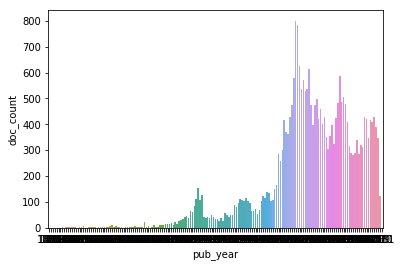

In [524]:
#plot number of documents by year
##at a glance, it appears that anything far in the past is not going to have many documents
##this was just a quick visualization. Could be improved significantly
sns.barplot(doc_count_df.pub_year,doc_count_df.doc_count)

In [525]:
#only going to look at publications after 1900. I ran a test with all and was seeing a large amount of error with the earlier years. 
df = df[df.pub_year>1900]

In [526]:
#check null density on the rest of the data set
##looks like there is a lot, but we might still be able to work with what is in those columns. Will keep them for now. 
df.isnull().sum()/len(df)

index                      0.000000
Corporate Name             0.201576
Subordinate Unit           0.360450
Title                      0.000297
Remainder Of Title         0.457633
Remainder OF Title Page    0.598632
Geographic Name            0.229040
General Subdivision        0.238554
pub_year                   0.000000
dtype: float64

In [527]:
#however, I am going to replace cases where no information provided with text "some_text". Using this word explicitly, so I can recognize it if it comes up later
df.replace({np.nan:''},inplace=True)

### With the rest of the text columns, going to execute the following:
- Set all words to lowercase
- Remove punctuation
- Remove stop words
- Remove words with fewer than 2 characters
- Tokenize 
- Stem

In [528]:
#rename columns, so they are easier to work with moving forward
for col in df.columns:
    new_col = col.replace(' ','_').lower()
    df.rename({col:new_col},inplace=True,axis=1)

In [529]:
# nltk.download('stopwords')

In [530]:
# nltk.download('punkt')

In [531]:
stop = set(stopwords.words('english') + list(string.punctuation))

In [532]:
stemmer = PorterStemmer()
re_punct = re.compile('[' + ''.join(string.punctuation) + ']')

In [533]:
#set all text to lowercase, tokenize, replace stopwords and punctation, stem all words
def preprocess(text):
    try:
        text = text.lower()
        tokens = word_tokenize(text)
        tokens = [t for t in tokens if not t in stop]
        tokens = [re.sub(re_punct, '', t) for t in tokens]
        tokens = [t for t in tokens if len(t) > 2]
        tokens = [stemmer.stem(t) for t in tokens]
        if len(tokens) == 0:
            return None
        else:
            return ' '.join(tokens)
    except:
        return None

In [534]:
#run pre-processing function on all text columns
text_cols = list(df)
text_cols.remove('pub_year')
for col in text_cols:
    processed_col = '_'.join(['p',col])
    df[processed_col] = df[col].apply(preprocess)

In [535]:
#drop old text columns
df.drop(text_cols,axis=1,inplace=True)

In [536]:
#combining all text into one column for now. Unless I can't develop a predictive model, I don't know how important labeling the different sections are going to be
text_cols = list(df)
text_cols.remove('pub_year')
df['all_text'] = df[text_cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Feature Engineering 

### Bag of Words Using TFIDF

In [537]:
df.replace({None:'some_text'},inplace=True)

In [538]:
text_data = np.array(df.all_text)

In [539]:
# min_df > word must appear in at least 30 documents
# max_df > word can appear in at most 1% of the documents
##using these numbers to get at words that are rarely used, thus likely used in a specific year, but not widely across documents
tfidf = TfidfVectorizer(min_df=30, max_df=0.01) #ngram_range=(1,5)

In [540]:
X = tfidf.fit_transform(text_data)

# Modeling

### Train/Test Split

In [541]:
y = df.pub_year.astype(int)

In [542]:
#split data 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2393)

### Feature Selection

In [543]:
#get number of features after vectorizing
total_features = len(tfidf.get_feature_names())
print('{} total features prior to selection'.format(total_features))

1094 total features prior to selection


In [544]:
#select the top 500 words most closely associated with pub_year based on chi-squared test
ch2 = SelectKBest(chi2, k=500)
X_train = ch2.fit_transform(X_train, y_train)
X_test = ch2.transform(X_test)

In [545]:
#show the top 50 features being used
##notice there are a lot of dates that rise to the surface
##This makes sense. If you can find a date in body of the article, it's probably a good predictor of the pub_date
feature_scores = pd.DataFrame([tfidf.get_feature_names(), ch2.scores_.tolist()]).T.rename(columns={0:'token',1:'ch2'})
feature_scores.sort_values(by='ch2',ascending=False,na_position='last').head(50)

,token,ch2
25,1977,1236.27
4,1939,1149.77
28,1979,1138.24
1,1915,1040.38
2,1936,1003.66
709,odwyer,1002.5
1014,theater,1002.44
24,1976,993.945
26,1978,932.303
38,1989,827.927


In [546]:
#fit a linear support vector classifier
##Based on my research, SVMs perform well for this sort of problem, as they tend to handle high dimensionality really well, which we very much have here.
classifier = LinearSVC()
classifier.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [547]:
#although I am treating this as a classification problem, traditional performance measures do not adequately reveal how well the classifier performs
print('Accuracy: {}'.format(round(classifier.score(X_test, y_test), 3)))

Accuracy: 0.125


In [548]:
#get predictions from test set
preds = pd.Series(classifier.predict(X_test))

In [549]:
#set up predicted vs actuals data
results = pd.concat([y_test.reset_index(drop=True),preds.reset_index(drop=True)],axis=1).rename({'pub_year':'actual',0:'predicted'},axis=1)
results['error'] = results.actual-results.predicted

In [550]:
#take a look at 50 random predictions
##you can start to see why accuracy is a poor measure of performance here. The 3rd record here is only off by 3 years, but using accuracy
##we are penalizing it just as much as the first prediction
results.sample(50)

,actual,predicted,error
4069,1969,1964,5
1909,1967,1967,0
2852,1992,1993,-1
1607,1993,1993,0
5225,1998,1995,3
281,1979,1967,12
3102,1978,2006,-28
3174,2002,1967,35
1157,1985,1994,-9
103,1993,1961,32


In [551]:
#calulcate the root mean squared error
def rmse(actuals,predictions):
    return round(np.sqrt(((actuals-predictions) ** 2).mean()),3)
rmse(results.actual,results.predicted)

21.986

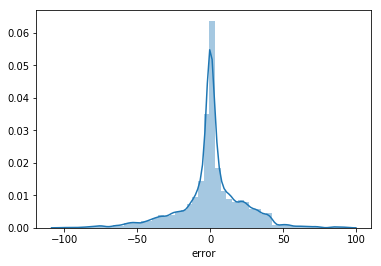

In [552]:
#show distribution of error
sns.distplot(results.error)

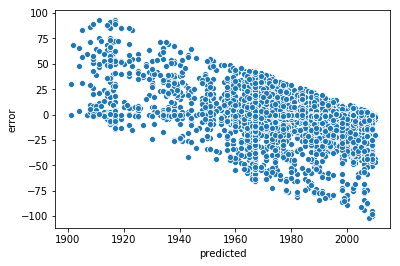

In [553]:
#show residual plot
##this is violating the zero-mean assumption of regression, but it makes more sense when looking at it in terms of classification
sns.scatterplot(results.predicted,results.error)